In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt

In [2]:
a=pd.read_csv('./TSPA.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])


In [3]:
coordinates=tspa[['x', 'y']].values

In [4]:
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)

In [5]:
costs=tspa[['val']].values

In [6]:
def plot_solution(result_list: list, coordinates: np.ndarray, weights: np.ndarray) -> None:
    plt.figure(figsize=(12, 6))
    for i1, i2 in zip(result_list, result_list[1:] + result_list[:1]):
        point1 = coordinates[i1]
        point2 = coordinates[i2]
        plt.plot(
            [point1[0], point2[0]],
            [point1[1], point2[1]],
            c = 'black',
            zorder=1
        )

    scatter = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=weights, cmap='inferno', s=50)

    cbar = plt.colorbar(scatter)
    cbar.set_label('Weights')

    plt.show()


In [7]:
def get_random_solution(n: int) -> list[int]:
    a=np.arange(0,n)
    np.random.shuffle(a)
    return list(a[:np.ceil(n/2)])

In [14]:
def nn(starting_point: int, distance: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix=distance+costs
    cost_matrix = cost_matrix.T
    result_list=[starting_point]
    n = cost_matrix.shape[0]
    while(len(result_list) < np.ceil(n/2)):
        distances=cost_matrix[result_list[-1]]
        indices=np.arange(0,n)
        di_pairs=[(d, i) for d, i in zip(distances,indices) if i not in result_list]
        nearest_neighbor = min(di_pairs)
        result_list.append(nearest_neighbor[1])
    return result_list

In [65]:
def score(path: list, distance: np.ndarray, costs: np.ndarray) -> int:
    score=0
    for x in range(1,len(path)):
        score+=distance[path[x-1]][path[x]]+costs[path[x]]
    score+=distance[path[-1]][path[0]]+costs[path[0]]
    return int(score[0])


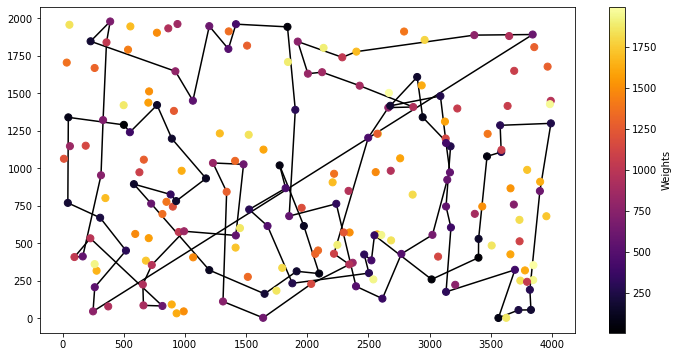

In [67]:

solution = nn(10, dist, costs)
plot_solution(solution, coordinates, costs)

In [87]:
def nn_whole_path(start_index: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix=distance_matrix+costs
    cost_matrix = cost_matrix.T
    n = len(cost_matrix)
    num_nodes_to_use = n // 2
    
    path = [start_index]
    unvisited = set(range(n)) - {start_index}
    
    while len(path) < num_nodes_to_use:
        best_insertion = None
        best_distance = float('inf')
        
        for node in unvisited:
            for i in range(len(path) + 1):
          
                if i == 0:
                    dist_change = cost_matrix[node][path[0]]
                elif i == len(path):
                    dist_change = cost_matrix[path[-1]][node]
                else:
                    dist_change = (cost_matrix[path[i-1]][node] + 
                                   cost_matrix[node][path[i]] - 
                                   cost_matrix[path[i-1]][path[i]])
                
                if dist_change < best_distance:
                    best_distance = dist_change
                    best_insertion = (node, i)
        
        if best_insertion:
            node, i = best_insertion
            path.insert(i, node)
            unvisited.remove(node)
    
    return path

In [94]:
def nn_whole_path_optimized(start_index: int, distance_matrix: np.ndarray, costs: np.ndarray) -> List[int]:
    cost_matrix = (distance_matrix + costs).T
    n = len(cost_matrix)
    num_nodes_to_use = n // 2
    
    path = [start_index]
    unvisited = set(range(n)) - {start_index}
    
    while len(path) < num_nodes_to_use:
        best_node, best_position, best_distance = min(
            (
                (node, i, (
                    cost_matrix[path[-1], node] if i == len(path) else
                    cost_matrix[node, path[0]] if i == 0 else
                    cost_matrix[path[i-1], node] + cost_matrix[node, path[i]] - cost_matrix[path[i-1], path[i]]
                ))
                for node in unvisited
                for i in range(len(path) + 1)
            ),
            key=lambda x: x[2]
        )
        
        path.insert(best_position, best_node)
        unvisited.remove(best_node)
    
    return path

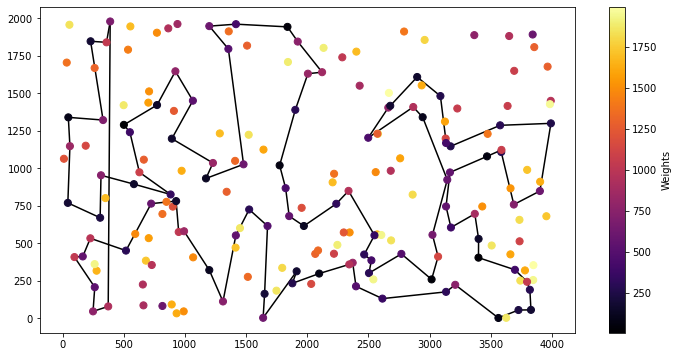

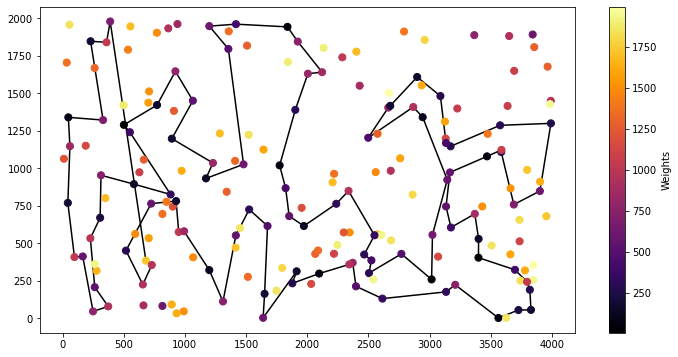

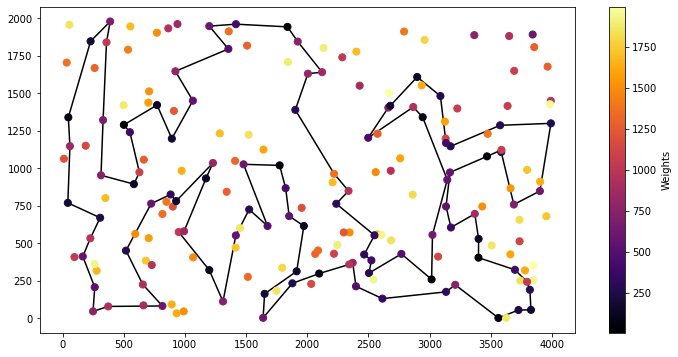

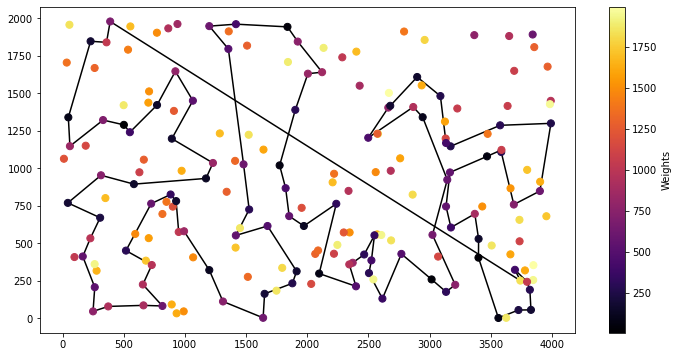

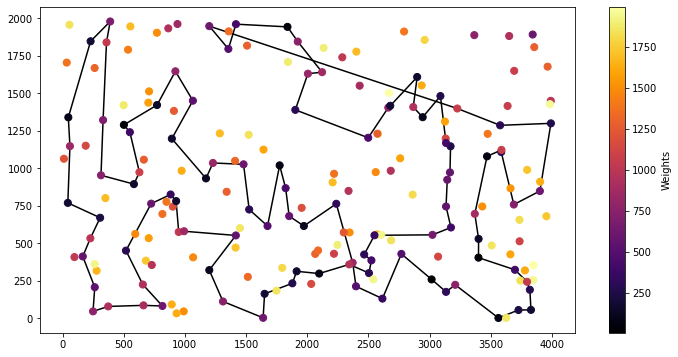

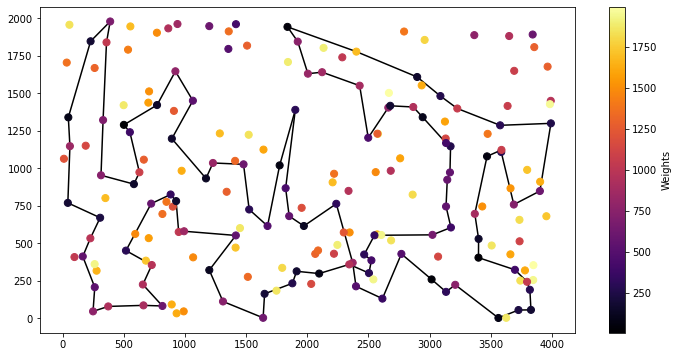

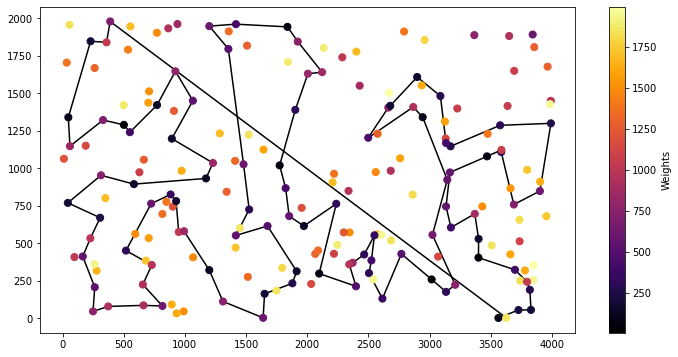

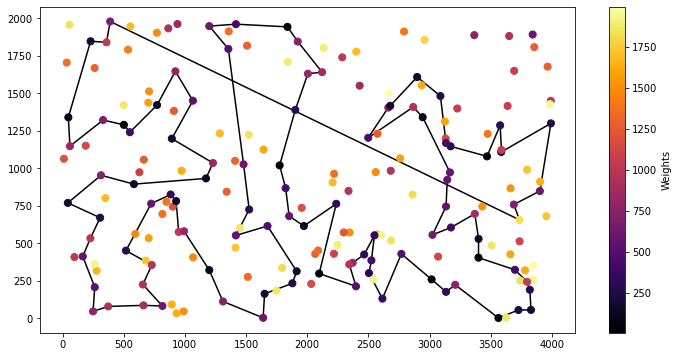

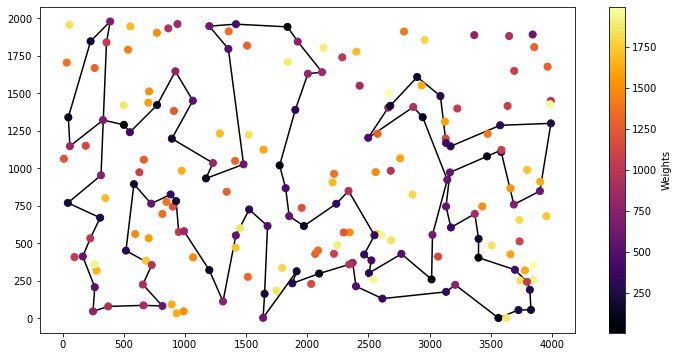

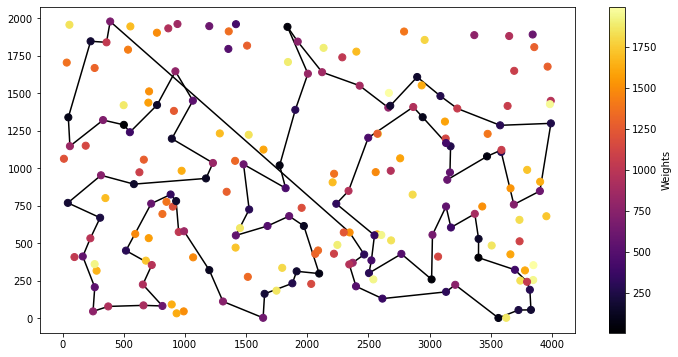

In [103]:
for i in range(10,20):
    solution = nn_whole_path(i, dist, costs)
    plot_solution(solution, coordinates, costs)


In [98]:
def nn_whole_path_vectorized(start_index: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list[int]:
    cost_matrix = (distance_matrix + costs).T
    n = len(cost_matrix)
    num_nodes_to_use = n // 2
    
    path = [start_index]
    unvisited = set(range(n)) - {start_index}
    
    while len(path) < num_nodes_to_use:
        best_distances = np.inf * np.ones(n)  
        best_insertion_indexes = np.zeros((n, 2), dtype=int) 
        
        for node in unvisited:
            
            dist_changes = np.zeros(len(path) + 1)
            dist_changes[0] = cost_matrix[node][path[0]] 
            dist_changes[-1] = cost_matrix[path[-1]][node]  
            
         
            if len(path) > 1:
                prev_nodes = path[:-1]
                next_nodes = path[1:]
                dist_changes[1:-1] = (cost_matrix[prev_nodes, node] + 
                                      cost_matrix[node, next_nodes] - 
                                      cost_matrix[prev_nodes, next_nodes])
            
            min_index = np.argmin(dist_changes)
            min_distance = dist_changes[min_index]
            if min_distance < best_distances[node]:
                best_distances[node] = min_distance
                best_insertion_indexes[node] = (node, min_index)
        
        best_node = np.argmin(best_distances)
        node, i = best_insertion_indexes[best_node]
        path.insert(i, node)
        unvisited.remove(node)
    
    return path

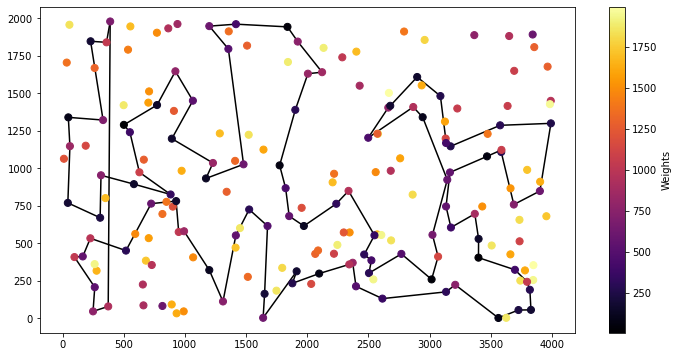

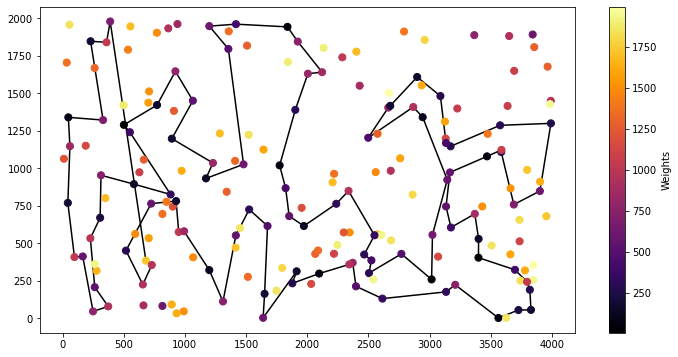

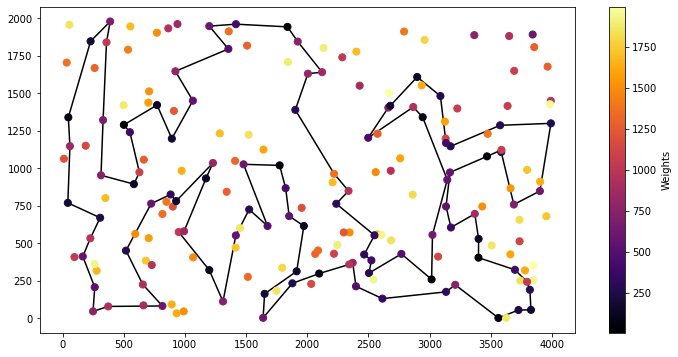

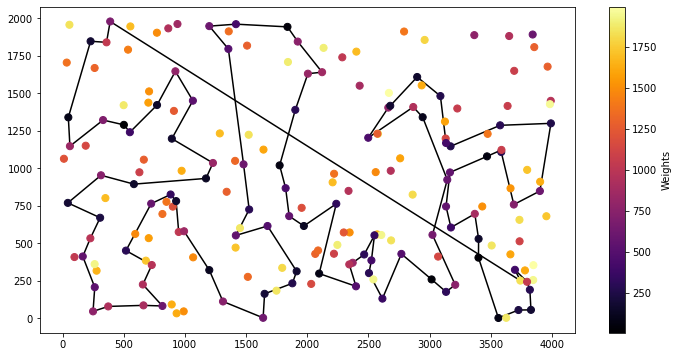

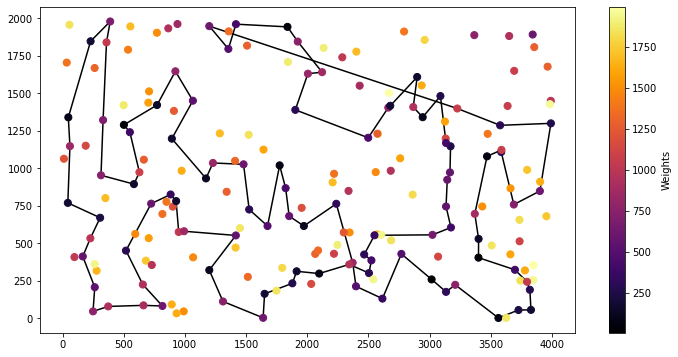

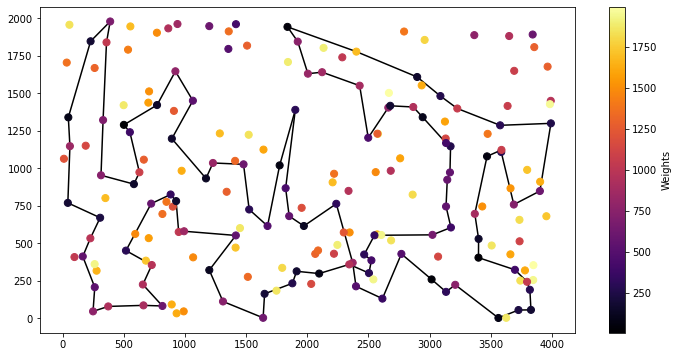

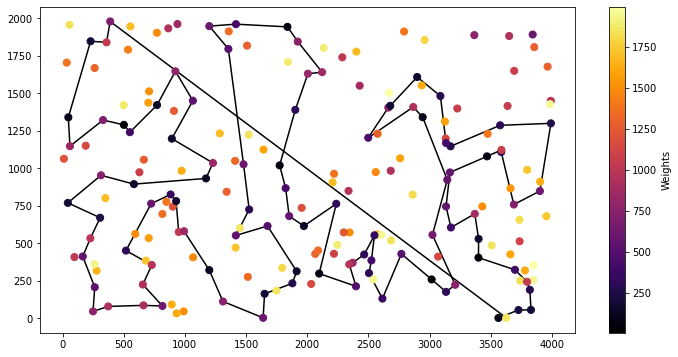

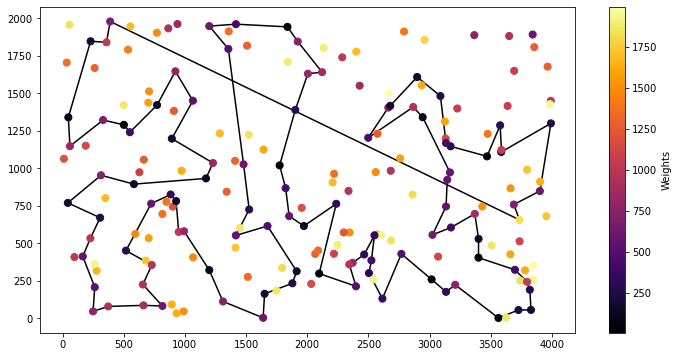

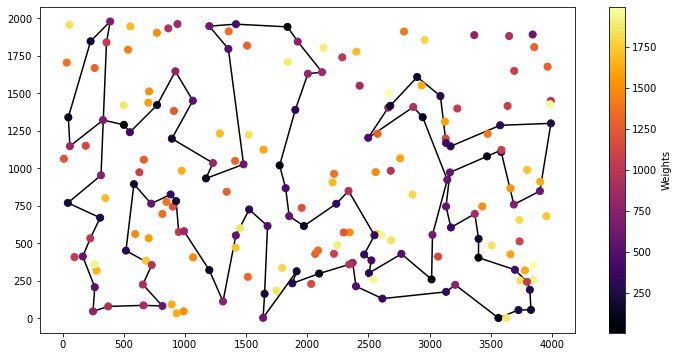

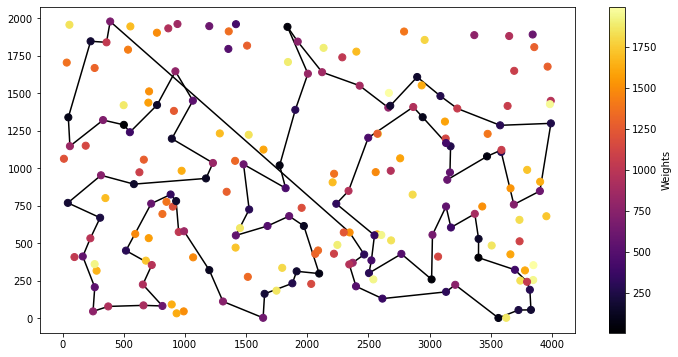

In [104]:
for i in range(10,20):
    solution = nn_whole_path_vectorized(i, dist, costs)
    plot_solution(solution, coordinates, costs)

In [100]:
%%timeit
nn_whole_path_vectorized(10, dist, costs)

342 ms ± 6.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [92]:
%%timeit
nn_whole_path_optimized(10, dist, costs)

466 ms ± 5.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
